In [2]:
import numpy as np
from ssapp.data.AntennaDatasetLoaders import load_serialized_dataset,train_test_dataloader_split
from ssapp.data.Metrics import relRMSE
from ssapp.Utils import FigureSaver
from torch.utils.data.dataloader import DataLoader
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,Matern
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
%load_ext autoreload
%autoreload 2

figSaver = FigureSaver('GaussianProcessHyperParameterTuning')


'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
dataset = load_serialized_dataset('CircularHornDataset1')

kernel = ConstantKernel(10, constant_value_bounds="fixed") * RBF(length_scale=0.335,length_scale_bounds='fixed')
std_gp = Pipeline([('scaler', StandardScaler()), ('gp', GaussianProcessRegressor())])

def score(model,x,y):
    pred = model.predict(x)
    return relRMSE(y.reshape(len(y),-1),pred.reshape(len(pred),-1))


In [20]:
test_ratios =  np.logspace(-5,-0.1,num = 50,base = 3)


def model_vs_dataset_size(test_ratios,gp_model,dataset):
    training_size = []
    train_loss = []
    val_loss = []



    for idx,test_ratio in enumerate(test_ratios):
        train_dataloader, val_dataloader = train_test_dataloader_split(dataset,batch_size = None,TRAIN_TEST_RATIO=test_ratio)
        train_params, train_fields = next(iter(train_dataloader))
        training_size.append(len(train_params))
        val_params, val_fields = next(iter(val_dataloader))
        std_gp.fit(train_params,train_fields.reshape(len(train_fields),-1))

        train_loss.append(score(std_gp,train_params,train_fields))
        val_loss.append(score(std_gp,val_params,val_fields))
        print(f'Percent Done: {(idx+1)/len(test_ratios)*100}, Test Ratio: {test_ratio}, Training Size: {training_size[-1]}, Train Loss: {train_loss[-1]}, Val Loss: {val_loss[-1]}')

    return np.array(training_size),np.array(train_loss),np.array(val_loss)


def plot_model_vs_dataset_size(test_ratios,gp_model, dataset,title = '', fig_name = ''):

    training_size ,train_loss,val_loss = model_vs_dataset_size(test_ratios,gp_model,dataset)

    plt.figure()
    plt.loglog(training_size,train_loss,label = 'Training Error')
    plt.plot(training_size,val_loss,label = 'Val Error')
    plt.title(title)
    plt.xlabel('Num. Training Samples')
    plt.ylabel('relRMSE')
    plt.grid()
    plt.legend()
    figSaver.save('GP_Loss_vs_Dataset_Size')

Percent Done: 20.0, Test Ratio: 0.00411522633744856, Training Size: 16, Train Loss: 9.06779766378785e-12, Val Loss: 1.1630828453518454
Percent Done: 40.0, Test Ratio: 0.01580764824832087, Training Size: 63, Train Loss: 3.3180516646160546e-11, Val Loss: 0.1603934219278218
Percent Done: 60.0, Test Ratio: 0.06072126358366197, Training Size: 242, Train Loss: 1.9023638708458696e-09, Val Loss: 0.012482362453302184
Percent Done: 80.0, Test Ratio: 0.23324607134955727, Training Size: 932, Train Loss: 0.0001325961599280185, Val Loss: 0.01491459401617408
Percent Done: 100.0, Test Ratio: 0.8959584598407622, Training Size: 3583, Train Loss: 0.0005569966665138093, Val Loss: 0.0036845157712788444


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


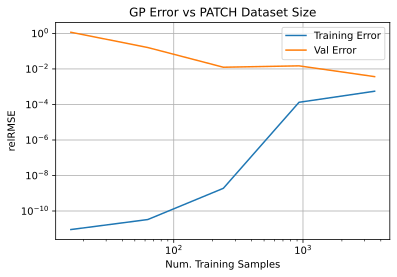

In [38]:
dataset = load_serialized_dataset('CircularHornDataset1')
#dataset = load_serialized_dataset('RFLCT')
#dataset = load_serialized_dataset('PatchAntennaDataset2')
#dataset = load_serialized_dataset('MLADataset1')

kernel = ConstantKernel(10, constant_value_bounds="fixed") * RBF(length_scale=0.335,length_scale_bounds='fixed')
std_gp = Pipeline([('scaler', StandardScaler()), ('gp', GaussianProcessRegressor(kernel=kernel))])

plot_model_vs_dataset_size(np.logspace(-5,-0.1,num = 5,base = 3),std_gp,dataset, title = 'GP Error vs PATCH Dataset Size', fig_name = 'CircularHornDataset1_error_vs_dataset_size')

In [64]:
# Define Test Rations
test_ratios = np.logspace(-4,-0.1,num = 10,base = 3)

# Run CHA Dataset
dataset = load_serialized_dataset('CircularHornDataset1')
kernel = ConstantKernel(10, constant_value_bounds="fixed") * RBF(length_scale=0.335,length_scale_bounds='fixed')
std_gp = Pipeline([('scaler', StandardScaler()), ('gp', GaussianProcessRegressor(kernel=kernel))])
CHA_training_size, CHA_train_loss, CHA_val_loss = model_vs_dataset_size(test_ratios,std_gp,dataset=dataset)

# Now for patch dataset
dataset = load_serialized_dataset('PatchAntennaDataset2')
kernel = ConstantKernel(0.5, constant_value_bounds="fixed") * Matern(length_scale=5,nu = 6.5,length_scale_bounds='fixed')
std_gp = Pipeline([('scaler', StandardScaler()), ('gp', GaussianProcessRegressor(kernel=kernel))])
PATCH_training_size, PATCH_train_loss, PATCH_val_loss = model_vs_dataset_size(test_ratios,std_gp,dataset=dataset)

# # Reflect Dataset
# dataset = load_serialized_dataset('RFLCT')
# kernel = ConstantKernel(1, constant_value_bounds="fixed") * RBF(length_scale=1,length_scale_bounds='fixed')
# std_gp = Pipeline([('scaler', StandardScaler()), ('gp', GaussianProcessRegressor(kernel=kernel))])
# RFLCT_training_size, RFLCT_train_loss, RFLCT_val_loss = model_vs_dataset_size(test_ratios,std_gp,dataset=dataset)

# # MLA Dataset
# dataset = load_serialized_dataset('MLADataset1')
# kernel = ConstantKernel(100, constant_value_bounds="fixed") * RBF(length_scale=40,length_scale_bounds='fixed')
# std_gp = Pipeline([('scaler', StandardScaler()), ('gp', GaussianProcessRegressor(kernel=kernel))])
# MLA_training_size, MLA_train_loss, MLA_val_loss = model_vs_dataset_size(test_ratios,std_gp,dataset=dataset)

Percent Done: 10.0, Test Ratio: 0.012345679012345678, Training Size: 49, Train Loss: 1.0831079424402892e-11, Val Loss: 0.24223437905801945
Percent Done: 20.0, Test Ratio: 0.019873187261241234, Training Size: 79, Train Loss: 3.8655652993433953e-11, Val Loss: 0.10388658010469368
Percent Done: 30.0, Test Ratio: 0.03199042932554921, Training Size: 127, Train Loss: 3.901592527890131e-10, Val Loss: 0.05514910067051695
Percent Done: 40.0, Test Ratio: 0.05149589519688552, Training Size: 205, Train Loss: 1.1980220350776795e-09, Val Loss: 0.019001652666864075
Percent Done: 50.0, Test Ratio: 0.08289439304306967, Training Size: 331, Train Loss: 5.4852580623176724e-08, Val Loss: 0.011233355462163669
Percent Done: 60.0, Test Ratio: 0.13343743946400036, Training Size: 533, Train Loss: 5.203440608043479e-06, Val Loss: 0.00835936376555653
Percent Done: 70.0, Test Ratio: 0.2147980049924181, Training Size: 859, Train Loss: 0.00012635976894945843, Val Loss: 0.018170480584685015
Percent Done: 80.0, Test Ra

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


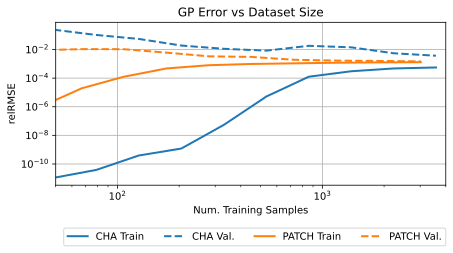

In [98]:
fig = plt.figure(figsize = (7,3))
plt.loglog(CHA_training_size,CHA_train_loss,label = 'CHA Train',c = 'C0',linewidth = 2)
plt.plot(CHA_training_size,CHA_val_loss,label = 'CHA Val.',c = 'C0',linewidth = 2,linestyle = '--')

plt.loglog(PATCH_training_size,PATCH_train_loss,label = 'PATCH Train',c = 'C1',linewidth = 2)
plt.plot(PATCH_training_size,PATCH_val_loss,label = 'PATCH Val.',c = 'C1',linewidth = 2,linestyle = '--')

#plt.loglog(RFLCT_training_size,RFLCT_train_loss,label = 'RFLCT Train',c = 'C2',linewidth = 2)
##plt.plot(RFLCT_training_size,RFLCT_val_loss,label = 'RFLCT Val.',c = 'C2',linewidth = 2,linestyle = '--')

#plt.loglog(MLA_training_size,MLA_train_loss,label = 'MLA Train',c = 'C3',linewidth = 2)
#plt.plot(MLA_training_size,MLA_val_loss,label = 'MLA Val.',c = 'C3',linewidth = 2,linestyle = '--')



plt.title('GP Error vs Dataset Size')
plt.xlabel('Num. Training Samples')
plt.ylabel('relRMSE')
plt.xlim([50,4e3])
plt.grid()
fig.legend(ncol = 4, loc = 'right', bbox_to_anchor = (0.91,-0.115))
figSaver.save('GP_Loss_vs_Dataset_Size')

In [ ]:
# Plot all datasets pca reconstruction error at 3 pcas

